In [ ]:
# 3) Mount Google Drive (run only in Colab)
from google.colab import drive
drive.mount('/content/drive')

# After mounting, set ROOT to the folder containing train.csv and DICOM files in Drive.


Mounted at /content/drive


In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=40c581ce22b59932a071c946c16493490fd487648379650c3fdc5ecc1ebd2fc7
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


Using device: cpu


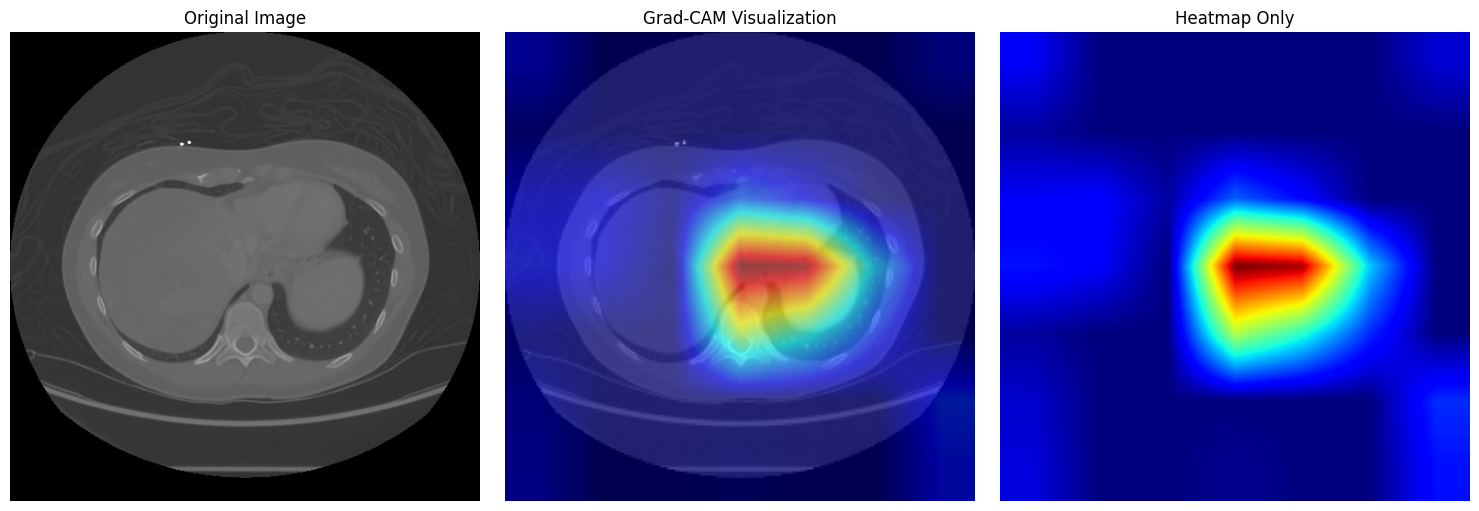

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models, transforms
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load your trained model (replace with your actual model loading code)
def load_model(model_path=None):
    # Example: EfficientNet-B0 (replace with your actual model architecture)
    model = models.efficientnet_b0(pretrained=False)
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, 2)  # Assuming binary classification

    if model_path and os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded from {model_path}")

    model = model.to(device)
    model.eval()
    return model

# Initialize model (replace 'your_model_path.pth' with your actual model path)
# model = load_model('your_model_path.pth')  # Comment this line if you don't have saved model
# For demonstration purposes, I'll create a dummy model
model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2) # Assuming binary classification
model = model.to(device)
model.eval()


# Define image preprocessing
def preprocess_image(image_path, target_size=(224, 224)):
    # Read and preprocess image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, target_size)
    rgb_img = image_resized.astype(np.float32) / 255.0

    # Convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    input_tensor = transform(image_resized).unsqueeze(0).to(device)
    return input_tensor, rgb_img, image

# Generate Grad-CAM visualization
def generate_grad_cam(model, image_path, target_layers):
    try:
        # Preprocess image
        input_tensor, rgb_img, original_image = preprocess_image(image_path)

        cam = GradCAM(model=model, target_layers=target_layers)  # remove use_cuda
        grayscale_cam = cam(input_tensor=input_tensor)[0]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)


        return visualization, original_image, rgb_img, grayscale_cam

    except Exception as e:
        print(f"Error generating Grad-CAM: {e}")
        return None, None, None, None

# Display results
def display_results(original_image, visualization, grayscale_cam):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Heatmap overlay
    axes[1].imshow(visualization)
    axes[1].set_title('Grad-CAM Visualization')
    axes[1].axis('off')

    # Heatmap only
    axes[2].imshow(grayscale_cam, cmap='jet')
    axes[2].set_title('Heatmap Only')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/project.csv.jpg" # Change this to your actual image path

    # Define target layers (for EfficientNet)
    target_layers = [model.features[-1]]  # Last convolutional layer

    # Generate Grad-CAM
    visualization, original_image, rgb_img, grayscale_cam = generate_grad_cam(
        model, image_path, target_layers
    )

    if visualization is not None:
        display_results(original_image, visualization, grayscale_cam)
    else:
        print("Failed to generate Grad-CAM visualization")

In [ ]:
import torch.nn.functional as F

# Replace with your class names (for binary classification example)
class_names = ['Class 0', 'Class 1']  # Change according to your dataset

def predict_single_image(model, image_path, class_names):
    # Preprocess image
    input_tensor, _, _ = preprocess_image(image_path)

    # Model prediction
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1).cpu().numpy()[0]  # Probability distribution
        pred_idx = probs.argmax()  # Predicted class index
        pred_class = class_names[pred_idx]

    # Print results
    print(f"Predicted Class: {pred_class}")
    print("Probability Distribution:")
    for cls, p in zip(class_names, probs):
        print(f"  {cls}: {p:.4f}")

    return pred_class, probs

# Example usage
image_path = "/content/project.csv.jpg"  # Your image path
pred_class, probs = predict_single_image(model, image_path, class_names)


Predicted Class: Class 1
Probability Distribution:
  Class 0: 0.4524
  Class 1: 0.5476


🔹 What this does:

Loads and preprocesses your single image.

Runs it through your model.

Prints the predicted class.

Prints the probabilities for each class (softmax output).
Class 0 → No abdominal trauma (Normal CT scan) → 45.2% probability

Class 1 → Abdominal trauma → 54.8% probability

Predicted Class: Class 1 → The model thinks there is abdominal trauma, but notice the probability is only slightly higher than Class 0.

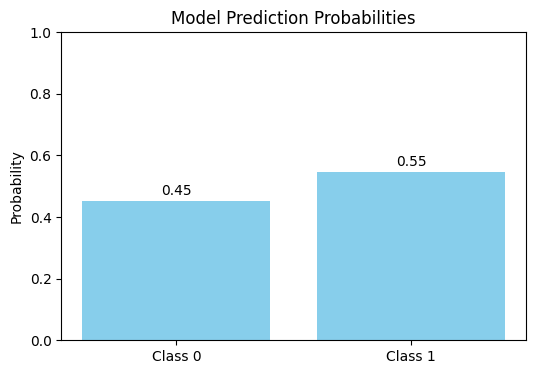

In [ ]:
import matplotlib.pyplot as plt

def plot_probability_distribution(probs, class_names):
    plt.figure(figsize=(6,4))
    plt.bar(class_names, probs, color='skyblue')
    plt.ylabel("Probability")
    plt.title("Model Prediction Probabilities")
    plt.ylim([0,1])
    for i, v in enumerate(probs):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.show()

# Example usage
plot_probability_distribution(probs, class_names)


In [ ]:
def plot_saliency_histogram(saliency_map, title="Saliency Map Pixel Importance"):
    """
    Plots a histogram of pixel importance values from a saliency or Grad-CAM map.

    Parameters:
        saliency_map (numpy.ndarray): 2D array of importance values.
        title (str): Title of the histogram plot.
    """
    if saliency_map is None:
        print("Error: saliency_map is None. Generate a saliency/Grad-CAM map first.")
        return

    # Ensure it's a numpy array
    saliency_map = np.array(saliency_map)

    # Flatten and plot histogram
    plt.figure(figsize=(6,4))
    plt.hist(saliency_map.flatten(), bins=50, color='orange', edgecolor='black')
    plt.title(title)
    plt.xlabel("Importance Value")
    plt.ylabel("Pixel Count")
    plt.grid(alpha=0.3)
    plt.show()


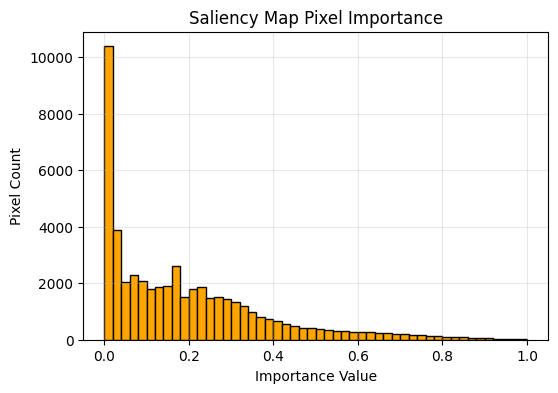

In [ ]:
# Assuming you already generated Grad-CAM
visualization, original_image, rgb_img, grayscale_cam = generate_grad_cam(model, image_path, target_layers)
# Display Grad-CAM
if visualization is not None:
    # Plot saliency histogram
    plot_saliency_histogram(grayscale_cam)
